# iGED : Global Systems Dynamics Initiative

El objetivo principal de este documento es analizar las métricas globales en las siguientes redes capitales

  *  Ciudad Autónoma de Buenos Aires (CABA)
  *  Ciudad de México (CDMX)
  *  Santiago de Chile (SCL)
  *  Montevideo (MTV)
  *  Madrid (MAD)
  *  Sao Paulo (SAO)

y obtener un tidy DataFrame, para continuar analizando los datos obtenidos, por ejemplo obteniendo correlaciones entre parejas de métricas.

Respecto al notebook anterior, utilizamos la documentación de NetworkX: https://www.nas.ewi.tudelft.nl/people/Piet/papers/TUDreport20111111_MetricList.pdf

así como el siguiente recurso: https://www.nas.ewi.tudelft.nl/people/Piet/papers/TUDreport20111111_MetricList.pdf

para saber con cuáles métricas globales seguir estudiando nuestros ecosistemas.

In [1]:
#-------------------------------------------------------
# Importar paquetes a utilizar
#-------------------------------------------------------
import pandas as pd
import numpy as np 
import networkx as nx
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

G={}

for i in range(200):
    G[i]=nx.read_graphml('Random_Graphs/Random_Graph_'+str(i+11)+'.graphml')


In [2]:
#--------------------------------
# Central point of Dominance
#--------------------------------


def central_point_dominance(G):
    betwennesses = nx.betweenness_centrality(G)
    b_max = max(betwennesses.values())
    N = len(betwennesses.keys())
    count = 0
    for i, b_i in betwennesses.items():
        count += ( b_max - b_i )/(N-1)
    return count

In [3]:
#--------------------------------
# Spectral Radius
#--------------------------------
#     the smaller the spectral radius rho, the higher the probability of 'virus infection' tau, 
#     the more difficult it is for an idea to spread in the innovative network, 
#     namely, the less efficient

import numpy.linalg

def spectral_radius(G):
    L = nx.normalized_laplacian_matrix(G)
    e = numpy.linalg.eigvals(L.A)
    e_abs = [abs(x) for x in e]
    return max(e_abs)

In [4]:
def core_ratio(G):
    return len(nx.k_core(G,k=2).nodes())/len(G.nodes())

In [5]:
def rich_club_coeffs(G):
    t_ok = True
    t = 0
    d = dict()
    while t_ok:
        nodes_large_degree=[]
        for x in G.nodes():
            if G.degree(x)>t:
                nodes_large_degree.append(x)
        core = G.subgraph(nodes_large_degree)
        edges_core = len(core.edges())
        nodes_core = len(core.nodes())
        if nodes_core<=1:
            t_ok = False
            break
        d[t] = (2*edges_core)/(nodes_core*(nodes_core-1))
        t += 1 
    return d        

def max_rich_club(G):
    #rich_club_1=nx.algorithms.rich_club_coefficient(G, normalized=False)
    rich_club=rich_club_coeffs(G)
    max_i=0
    for i in range(len(rich_club)):
        if rich_club[i]>rich_club[max_i]:
            max_i=i
        else:
            return rich_club[max_i]

In [6]:
def eccentricity(G):
    excentricidades=nx.algorithms.distance_measures.eccentricity(G)
    excentricidad=0
    for i in excentricidades.keys():
        excentricidad+=excentricidades[i]
    return excentricidad/len(excentricidades.keys())

## Creacion del Dataframe

El siguiente bloque crea todas las metricas de la grafica que usaremos para estudiarlas.

In [7]:
n=len(G)

degree = n*[0]
diameter = n*[0]
radius = n*[0]
avg_shortest_path_length = n*[0]
transitivity = n*[0]
global_efficiency = n*[0]
modularity = n*[0]
rich_club_coefficient = n*[0]
core_rate= n*[0]
central_pt = n*[0]
spectral_radii = n*[0]
excentricidad = n*[0]
modularidad=n*[0]

for index in G.keys():
    graph=G[index]
    
    #conseguimos cada parámetro para esta ciudad
    degree[index]=                        2*len(graph.edges())/len(graph.nodes())
    diameter[index] =                     nx.diameter(graph)
    radius[index] =                       nx.radius(graph)
    avg_shortest_path_length[index] =     nx.average_shortest_path_length(graph)
    transitivity[index] =                 nx.transitivity(graph)
    global_efficiency[index] =            nx.global_efficiency(graph)
    #modularidad precomputada
    rich_club_coefficient[index] =        max_rich_club(graph)  
    core_rate[index]=                     core_ratio(graph)
    central_pt[index]=                    central_point_dominance(graph)
    spectral_radii[index]=                spectral_radius(graph)
    excentricidad[index]=                 eccentricity(graph)
    modularidad[index]=                   nx.algorithms.community.quality.performance(graph,nx.algorithms.community.modularity_max.greedy_modularity_communities(graph))

df=pd.DataFrame()


df['Eficiencia Global'] = global_efficiency
df['Degree']= degree
df['Transitividad'] = transitivity
df['Modularidad'] = modularidad
df['Excentricidad']= excentricidad
df['Radio'] = radius
df['Rich Club Coefficient'] = rich_club_coefficient
df['Core Ratio'] = core_rate
df['Central Point Dominance'] = [round(central_pt[index],3) for index in range(n)]
df['Spectral radius'] = [round(spectral_radii[index],3) for index in range(n)]
df['Camino más corto promedio'] = avg_shortest_path_length
df['Diámetro'] = diameter


## Colaboracion

Empezamos analizando las metricas que ya hemos calculado y luego usaremos esta informacion para crear una medida de la colaboracion.

In [15]:
#---------------------------------------------
#Preparar escalas y herramientas para el analisis.
#---------------------------------------------

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X=df.to_numpy()



normalized= StandardScaler().fit_transform(X)
pca=PCA(n_components=5)
prin_comp=pca.fit_transform(normalized)

pca.components_

array([[-0.33762088, -0.32514881, -0.29913228,  0.28455505,  0.31872538,
         0.20798608, -0.33018749, -0.26677212,  0.15517596,  0.30475987,
         0.3368958 ,  0.23312344],
       [ 0.03807743, -0.21098535,  0.06884616,  0.10413216, -0.23018094,
        -0.50722015,  0.00410757, -0.31999108,  0.61965165,  0.12473771,
        -0.06762043, -0.34883391],
       [ 0.13450848,  0.07916039,  0.17302838, -0.2974906 ,  0.1102266 ,
         0.31019638,  0.21366412,  0.08827237,  0.65338053,  0.04902091,
        -0.09632769,  0.50675179],
       [-0.00610276, -0.02931355, -0.33930447, -0.09713453, -0.10683198,
         0.56802916, -0.06949737,  0.27819355,  0.26425033, -0.01809569,
        -0.02570028, -0.62244108],
       [-0.05254446,  0.02221121, -0.44645357,  0.10000942,  0.08663571,
        -0.46205709, -0.11045935,  0.6823147 ,  0.18660982, -0.13095668,
         0.02425131,  0.19001302]])

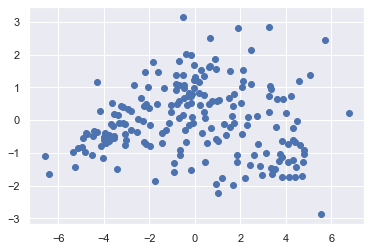

In [16]:
from matplotlib import pyplot as plt
plt.scatter(prin_comp[:,0], prin_comp[:,1],color='b')

In [64]:
#---------------------------------------
# Fórmula para colaboratividad
#---------------------------------------

eg = df['Eficiencia Global'].tolist()
tr = df['Transitividad'].tolist()
comunicacion = [eg[x]+tr[x] for x in range(n)]

r= df['Radio'].tolist()
sr= df['Spectral radius'].tolist()
size=[-r[x]/28-sr[x]/5 for x in range(n)]

rcc = df['Rich Club Coefficient'].tolist()
cr = df['Core Ratio'].tolist()
preparacion = [(rcc[x]+cr[x])/2 for x in range(n)]

colab={}

colab = {comunicacion[x]+preparacion[x]+size[x]: x for x in range(n)}
order_colab=list(colab.keys())
order_colab.sort()
ratio=0
for i in range(40):
    if colab[order_colab[i]]<101:
        ratio+=1
ratio/40

1.0

In [60]:
#Bad number between 11 and 35 is higher than 36 to 60

eg = df['Eficiencia Global'].tolist()
tr = df['Transitividad'].tolist()
comunicacion = [eg[x]+tr[x] for x in range(n)]

r= df['Radio'].tolist()
sr= df['Spectral radius'].tolist()
size=[-r[x]/28-sr[x]/5 for x in range(n)]

rcc = df['Rich Club Coefficient'].tolist()
cr = df['Core Ratio'].tolist()
preparacion = [(rcc[x]+cr[x])/2 for x in range(n)]

colab = {((comunicacion[x]**2+preparacion[x]**2+size[x]**2)/3)**(1/2): x for x in range(n)}
order_colab=list(colab.keys())
order_colab.sort()
ratio=0
for i in range(40):
    if colab[order_colab[i]]<101:
        ratio+=1
ratio/40

0.9

In [61]:
eg = df['Eficiencia Global'].tolist()
comunicacion = [eg[x] for x in range(n)]

rcc= df['Rich Club Coefficient'].tolist()
mod= df['Modularidad'].tolist()
futuro=[(rcc[x]+1-mod[x])/2 for x in range(n)]

tr = df['Transitividad'].tolist()
resistencia = [tr[x] for x in range(n)]

colab = {((comunicacion[x]**2+futuro[x]**2+resistencia[x]**2)/3)**(1/2): x for x in range(n)}
order_colab=list(colab.keys())
order_colab.sort()
ratio=0
for i in range(40):
    if colab[order_colab[i]]<101:
        ratio+=1
ratio/40

1.0

In [66]:
eg = df['Eficiencia Global'].tolist()
comunicacion = [eg[x] for x in range(n)]

r= df['Transitividad'].tolist()
size=[r[x] for x in range(n)]

rcc = df['Core Ratio'].tolist()
md= df['Modularidad'].tolist()
preparacion = [1-(rcc[x]/2+md[x]/2) for x in range(n)]

colab = {comunicacion[x]+preparacion[x]+size[x]: x for x in range(n)}
order_colab=list(colab.keys())
order_colab.sort()
ratio=0
for i in range(40):
    if colab[order_colab[i]]<101:
        ratio+=1
ratio/40

0.975

In [67]:
for i in range(200):
    print(colab[order_colab[i]])

85
98
80
69
84
78
88
75
92
91
49
83
29
72
22
81
28
86
55
18
77
66
71
79
89
93
95
54
57
99
90
70
5
96
97
73
67
82
68
106
20
36
76
35
50
64
42
25
44
32
62
56
144
6
23
122
8
48
59
34
108
105
1
26
94
101
87
27
51
61
45
140
63
39
60
7
53
65
15
38
135
47
113
2
31
21
156
52
161
46
74
10
102
17
159
121
13
40
143
41
3
9
107
126
37
24
195
120
110
141
109
100
165
137
58
131
16
128
43
104
160
19
114
178
14
138
116
115
132
182
0
119
111
133
30
168
155
180
174
136
149
103
147
118
177
33
125
179
154
186
191
146
172
175
152
11
171
193
170
181
196
190
185
167
150
123
12
151
117
153
142
198
127
184
134
158
187
176
139
4
124
197
173
157
162
129
183
189
166
169
130
148
164
192
112
163
145
199
194
188


In [70]:
eg = df['Eficiencia Global'].tolist()
comunicacion = [eg[x] for x in range(n)]

r= df['Transitividad'].tolist()
size=[r[x] for x in range(n)]

rcc = df['Core Ratio'].tolist()
md= df['Modularidad'].tolist()
preparacion = [1-(rcc[x]/2+md[x]/2) for x in range(n)]

colab = {((comunicacion[x]**2+preparacion[x]**2+size[x]**2)/3)**(1/2): x for x in range(n)}
order_colab=list(colab.keys())
order_colab.sort()
ratio=0
for i in range(40):
    if colab[order_colab[i]]<101:
        ratio+=1
ratio/40

1.0

In [69]:
eg = df['Eficiencia Global'].tolist()
comunicacion = [eg[x] for x in range(n)]

r= df['Transitividad'].tolist()
size=[r[x] for x in range(n)]

rcc = df['Excentricidad'].tolist()
md= df['Modularidad'].tolist()
preparacion = [1/rcc[x]-md[x]/2 for x in range(n)]

colab = {comunicacion[x]+preparacion[x]+size[x]: x for x in range(n)}
order_colab=list(colab.keys())
order_colab.sort()
ratio=0
for i in range(40):
    if colab[order_colab[i]]<101:
        ratio+=1
ratio/40

1.0